# Veri Yogun Uygulamalar Modul Projesi: Zaman serisi siniflandirma problemi

Dr. Ismail Guzel

Milli Teknoloji Hamlesi altinda Yapay Zeka Uzmanlık Programı kapsamında 18 saatlik Veri Yogun Uygulamar egitimi sonunda bu projenin tamamlanmasi beklenilmektedir. 

Bu proje icerisinde amac farkli sektorlerden elde dilmis zaman serileri uzerinden elde edilen faktorler uzerine kurulmus bir classification modeli kurarak benzerlik calismasi yapmaktir.

Mesela ilgilenilen bir hisse senedi X olsun, bunun bulundugu sektor bazli diger hisse senetlerin davranislarindan farkli davrandigini dusunelim. Yani sektor icinde bir artis gozlemlenirken bu hisse senetinde bir hareketlilik olmasin. Dolayisiyla, hangi sektore daha cok benziyor sorusuna cevap verebilirsek, o sektor'un hareketlerine gore bir hipotez kurabiliriz.

Bu proje, asagidaki surecleri kapsayacak:

- Sektorleriin listesine bir web-scraping ile erisilmesi ve verilerin elde edilmesi (`yfinance`, `investpy`, [`quandl`]((https://docs.data.nasdaq.com/v1.0/docs/python-installation)))
- 2005-01-01 yilindan itibaren aylik getirelerden olusan serilerin elde edilmesi
- 3 buyuk sektor uzerinden getirilerin faktorleri(momentum gibi) hesaplanmasi
- Bu momentum serileri uzerinden bir tsfresh ile feature engineering yapilmasi (imputing, encoding, transformation, ve daha fazlasi)
- Yeni elde edilmis feature ve sektor siniflari uzerinden bir model kurulmasi (en iyi model secmesi)
- Diger sektorlerden ornekler alip ayni feature engine yontemleri yaptik sonra hangi sektore benzedigine karar vermek.
- **Bonus** Mesela Real-Estate sektorunde bulunan butun sembollerin tahmini edildikten sonra cogunluk hangi sektore(T,F,H) benzedigi bilgisine erismek.

In [117]:
import yfinance
import pandas as pd
import requests
from bs4 import BeautifulSoup

def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

In [118]:
sectors=fetch_sectors_names()
indusrty=fetch_industry_names()

In [119]:
sectors

,Sector Name,Stocks,Market Cap,Div. Yield,PE Ratio,Profit Margin,1D Change,1Y Change
0,Financials,1394,"9,654.16B",2.39%,14.68,17.81%,0.20%,107.28%
1,Healthcare,1219,"8,190.44B",0.42%,50.64,4.11%,0.31%,2.47%
2,Technology,788,17.83T,0.42%,44.79,13.21%,1.62%,8.65%
3,Industrials,650,"5,432.80B",1.10%,26.52,7.32%,0.64%,8.17%
4,Consumer Discretionary,578,"7,315.94B",0.64%,27.68,5.92%,0.68%,-3.84%
5,Materials,263,"2,042.11B",1.56%,19.21,8.76%,1.03%,-5.90%
6,Real Estate,260,"1,525.70B",4.06%,49.91,9.22%,0.35%,3.89%
7,Communication Services,260,"5,272.98B",1.08%,27.55,10.39%,1.05%,-7.45%
8,Energy,253,"3,553.66B",2.94%,6.81,13.72%,0.99%,0.25%
9,Consumer Staples,242,"4,017.29B",1.44%,28.67,4.86%,0.04%,4.13%


## Sektor listerine erismek

Yukarida yazilan fonksyionlar ile hangi sembollerin hangi sektorlerde oldugu bilgisine erisim saglanabilir ve asagidaki betikler yardimi ile `.csv` dosyalarinda saklayabiliriz. Sonrasinda, sektor bazli sembollere ait verileri indirilebilir ve siniflandirilabilir.

In [120]:
fetch_data(sectors='energy').to_csv('../data/stock_sectors/energy.csv')
fetch_data(sectors='financials').to_csv('../data/stock_sectors/financials.csv')
fetch_data(sectors='healthcare').to_csv('../data/stock_sectors/healthcare.csv')
fetch_data(sectors='technology').to_csv('../data/stock_sectors/technology.csv')
fetch_data(sectors='utilities').to_csv('../data/stock_sectors/utilities.csv')
fetch_data(sectors='real-estate').to_csv('../data/stock_sectors/real-estate.csv')
fetch_data(sectors='materials').to_csv('../data/stock_sectors/materials.csv')
fetch_data(sectors='technology').to_csv('../data/stock_sectors/technology.csv')
fetch_data(sectors='industrials').to_csv('../data/stock_sectors/industrials.csv')
fetch_data(sectors='consumer-staples').to_csv('../data/stock_sectors/consumer-staples.csv')
fetch_data(sectors='consumer-discretionary').to_csv('../data/stock_sectors/consumer-discretionary.csv')
fetch_data(sectors='communication-services').to_csv('../data/stock_sectors/communication-services.csv')

In [123]:
finance = pd.read_csv('../data/stock_sectors/financials.csv')
finance.Symbol

0       BRK.B
1           V
2         JPM
3          MA
4         BAC
        ...  
1002     RELI
1003     NCPL
1004     TIRX
1005      DXF
1006    AIMAU
Name: Symbol, Length: 1007, dtype: object

## Veriye erismek
Diyelim ki, finans sektorunden `HSBC` sembolu icin verileri indirmek istiyoruz. Bu adim icin `yfinance` kullanilabilir. Oncelikle `.Ticker` ile bir object olusturup onun uzerinden dogru hissemi olduguna dair bilgileri teyit edebiliriz. Sonrasinda `.get_history_metadata()` ile sembolun metedatasina erisim saglayabiliriz. Sonrasinda, `.history(period='3y')` ile 3 yillik veriyi calisma ortamimiza indirebiliriz.

In [124]:
import yfinance
ticker_name = yfinance.Ticker("HSBC")
ticker_name.info

{'address1': '8 Canada Square',
 'city': 'London',
 'zip': 'E14 5HQ',
 'country': 'United Kingdom',
 'phone': '44 20 7991 8888',
 'fax': '44 20 7992 4880',
 'website': 'https://www.hsbc.com',
 'industry': 'Banks - Diversified',
 'industryKey': 'banks-diversified',
 'industryDisp': 'Banks - Diversified',
 'sector': 'Financial Services',
 'sectorKey': 'financial-services',
 'sectorDisp': 'Financial Services',
 'longBusinessSummary': 'HSBC Holdings plc provides banking and financial services worldwide. The company operates through Wealth and Personal Banking, Commercial Banking, and Global Banking and Markets segments. The Wealth and Personal Banking segment offers retail banking and wealth products, including current and savings accounts, mortgages and personal loans, credit and debit cards, and local and international payment services; and wealth management services comprising insurance and investment products, global asset management services, investment management, and private wealth 

In [126]:
ticker_name.get_history_metadata()

{'currency': 'USD',
 'symbol': 'HSBC',
 'exchangeName': 'NYQ',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 932131800,
 'regularMarketTime': 1709833492,
 'hasPrePostMarketData': True,
 'gmtoffset': -18000,
 'timezone': 'EST',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 37.87,
 'chartPreviousClose': 30.64,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EST',
   'start': 1709802000,
   'end': 1709821800,
   'gmtoffset': -18000},
  'regular': {'timezone': 'EST',
   'start': 1709821800,
   'end': 1709845200,
   'gmtoffset': -18000},
  'post': {'timezone': 'EST',
   'start': 1709845200,
   'end': 1709859600,
   'gmtoffset': -18000}},
 'dataGranularity': '1d',
 'range': '3y',
 'validRanges': ['1d',
  '5d',
  '1mo',
  '3mo',
  '6mo',
  '1y',
  '2y',
  '5y',
  '10y',
  'ytd',
  'max']}

In [128]:
data=ticker_name.history(period='3y')
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-01 00:00:00-05:00,39.060001,39.160000,38.790001,38.980000,2206000,0.0,0.0
2024-03-04 00:00:00-05:00,38.689999,38.910000,38.680000,38.779999,2124700,0.0,0.0
2024-03-05 00:00:00-05:00,38.730000,39.119999,38.730000,38.930000,2212500,0.0,0.0
2024-03-06 00:00:00-05:00,39.150002,39.340000,38.990002,39.230000,3372300,0.0,0.0
2024-03-07 00:00:00-05:00,37.830002,38.029999,37.715000,37.869999,986622,0.0,0.0


Simdi ise, belirlenen sembollerin verilerini belli bir tarih sonrasinda cekebiliriz. Sonrasinda aylik getirileri hesaplayabiliriz. Proje kapsaminda bu yontem kullanilacak.

In [135]:
ticker_list=['AAPL', 'NVDA', 'INTC', 'ORCL', 'SONY']
data = yfinance.download(ticker_list, start='2005-01-01') 
data_close=data['Adj Close'].resample('M').last().pct_change()+1

[*********************100%%**********************]  5 of 5 completed


In [136]:
data_close

Ticker,AAPL,INTC,NVDA,ORCL,SONY
Date,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN
2005-02-28,1.166710,1.072397,1.264834,0.940450,1.020800
2005-03-31,0.928890,0.968320,0.819593,0.963707,1.059010
2005-04-30,0.865371,1.012484,0.922980,0.926282,0.917291
2005-05-31,1.102607,1.150120,1.235750,1.107266,1.015255
...,...,...,...,...,...
2023-11-30,1.113780,1.228684,1.146886,1.123888,1.034919
2023-12-31,1.013583,1.124161,1.058934,0.907237,1.101687
2024-01-31,0.957773,0.857314,1.242418,1.063576,1.032316


In [137]:
# 3 aylik momentum faktorleri
def get_rolling_ret(data, n): 
    return data.rolling(n).apply(np.prod)
calisilacak_veri = get_rolling_ret(data_close, 3).dropna()
calisilacak_veri

Ticker,AAPL,INTC,NVDA,ORCL,SONY
Date,,,,,
2005-04-30,0.937842,1.051387,0.956806,0.839506,0.991626
2005-05-31,0.886313,1.127587,0.934805,0.988417,0.986240
2005-06-30,0.883370,1.123876,1.124579,1.057692,0.860570
2005-07-31,1.182751,1.157798,1.233926,1.173876,0.885590
2005-08-31,1.179326,0.956783,1.132103,1.014844,0.902066
...,...,...,...,...,...
2023-11-30,1.012403,1.276238,0.947703,0.968812,1.033177
2023-12-31,1.126007,1.418150,1.138563,0.999016,1.149011
2024-01-31,1.081238,1.184155,1.508887,1.084457,1.177002


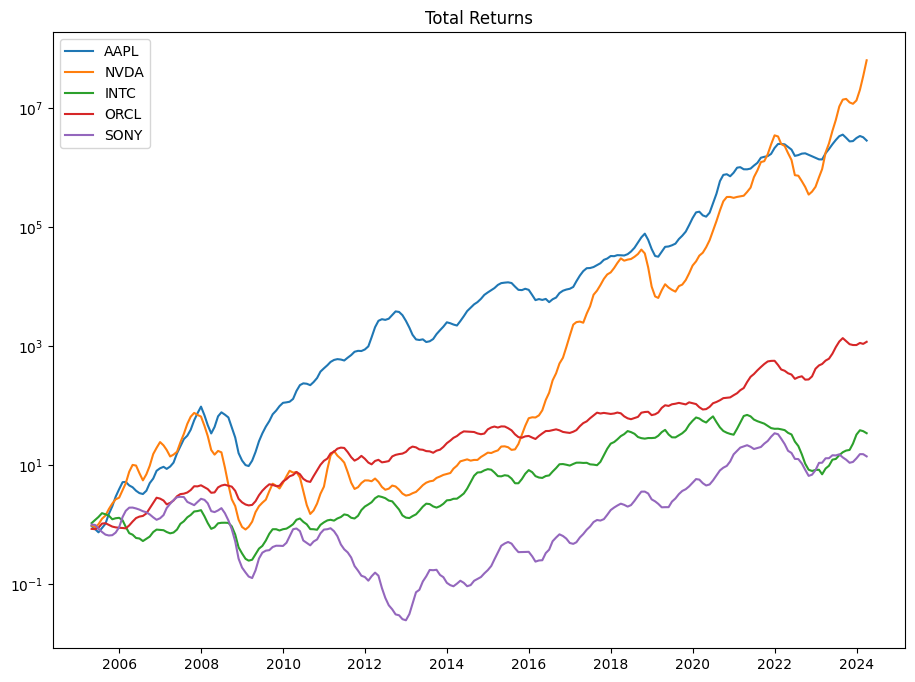

In [138]:
import matplotlib.pyplot as plt
plt.figure(figsize=[11,8])

for ticker in ticker_list:
    plt.plot(calisilacak_veri[ticker].cumprod(), label = ticker)

plt.yscale('log')
plt.title('Total Returns')
plt.legend()
plt.show()